# 1. Introduction

BlueSG is an electronic vehicle (EV) carsharing company in Singapore, supported by the Land Transport Authority and Economic Development Board. This report will look into 3 main issues: 
* (A) Which locations blueSG should move the electronic vehicles (EVs) into 
* (B) Vehicle charging constraints 
* (C) Demand fluctuation

# 2. Exploratory Data Analysis

In [1]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from gurobipy import *
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()
#import datetime
from datascience import *
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
%matplotlib inline
SMALL_SIZE = 14
BIGGER_SIZE = 18  
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = "bold")
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 1

In [2]:
# Read File
df = pd.read_csv("Car_Data.csv")

<b> Trip Duration </b>

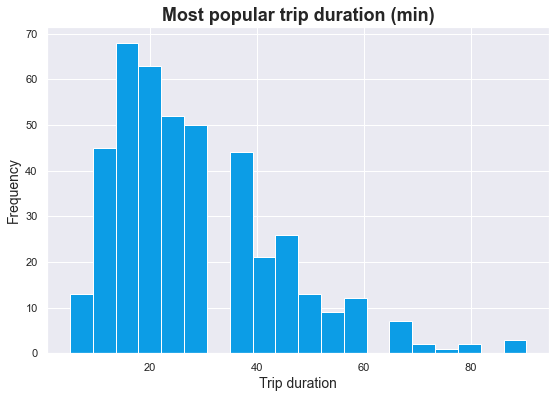

In [3]:
below_100min = df[df['trip_duration']<100]['trip_duration']
plt.title('Most popular trip duration (min)')
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
below_100min.hist(bins=20,facecolor='#0C9DE6')
plt.show()

From the above chart, trips typically around 20 minutes and are usually less than 1 hour.

In [4]:
print('The median trip duration is ' + str(np.median(df['trip_duration'])))

The median trip duration is 25.1


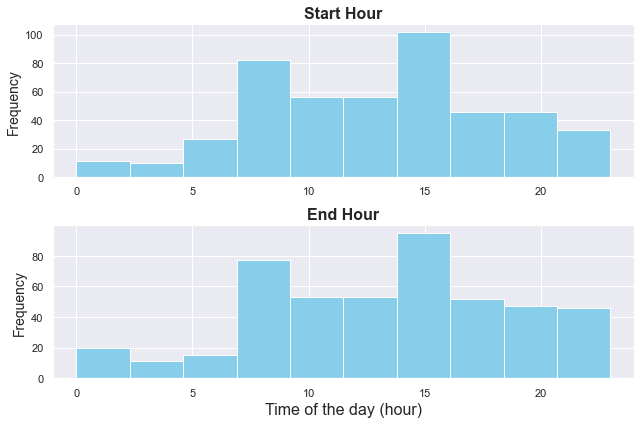

In [5]:
plt.subplot(2, 1, 1) 
plt.title('Start Hour', fontdict = {'fontsize': 16,
        'fontweight' : "bold"})
plt.hist(df['start_hour'], color = 'skyblue')
plt.ylabel('Frequency')
plt.xlim(-1,24)
#plt.xticks(range(0,24))

plt.subplot(2, 1, 2) 
plt.title('End Hour', fontdict = {'fontsize': 16,
        'fontweight' : "bold"})
plt.hist(df['end_hour'], color = 'skyblue', label = 'Male')
plt.xlabel('Time of the day (hour)', fontsize = 16 )
plt.ylabel('Frequency')
plt.xlim(-1,24)
#plt.xticks(range(0,24))

plt.tight_layout()
plt.show()
sns.set()
plt.rcParams['figure.figsize'] = [10, 8]

The most popular time of day to rent vehicles is between 9am to 3pm. 

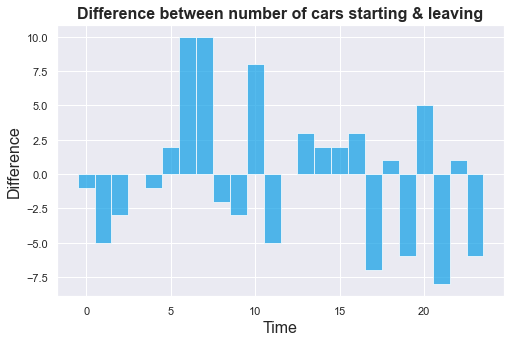

In [6]:
startCount = df.groupby('start_hour')['start_hour'].count()
endCount = df.groupby('end_hour')['end_hour'].count()

testTable = Table()
testTable = testTable.with_columns('Time', np.arange(24), 'Difference', startCount - endCount )
#Difference between number of cars that are arriving & leaving
testTable.bar('Time','Difference', facecolor='#0C9DE6', width = 8, height = 5)
plt.title('Difference between number of cars starting & leaving', fontdict = {'fontsize': 16,'fontweight' : "bold"})
plt.show()

<b> Demand by Weekday & Stations </b>

In [7]:
#Num of trips on each day
weekdays = df.groupby('weekday')['weekday'].count()

In [8]:
demand = pd.DataFrame(data={'num of trips': weekdays, 
                   'num of trips per day (demand)': round(weekdays*17.66,0)}).reset_index()

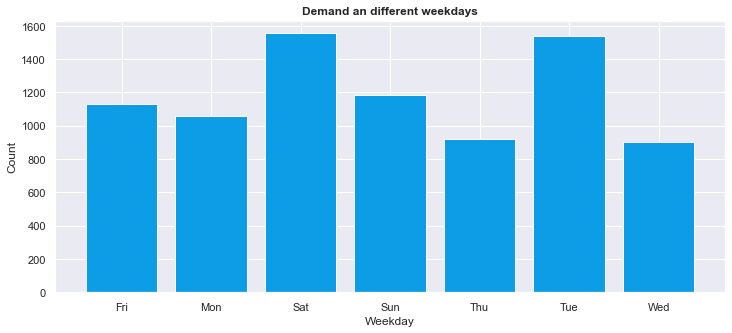

In [9]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.bar(demand['weekday'],demand['num of trips per day (demand)'],facecolor='#0C9DE6')
plt.title('Demand an different weekdays')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()

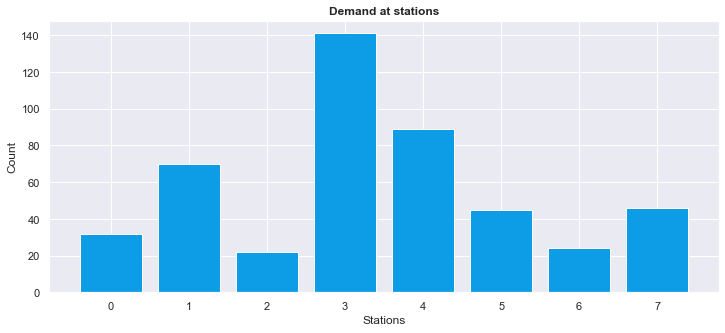

In [10]:
#Num of trips on each day
st = df.groupby('origin')['origin'].count()
plt.bar(np.arange(8),st,facecolor='#0C9DE6') 
plt.title('Demand at stations')
plt.xlabel('Stations')
plt.ylabel('Count')
plt.show()

# 3. Problem A - Where to Locate Electronic Vehicles (EVs)

<b> Average Trip Duration (between charging stations) </b>

For this model, Station 0-7 (8 stations) was used. 

The following is the estimated average trip duration (in minutes) between any of these 8 stations. When the origin and destination is the same station (meaning the customer picked up and dropped off the car at the same location), the trip duration is estimated to be 25 min. Hence, a travel time matrix can be made as shown.

<img src="locations.png" width = "500px">

In [11]:
traveldist = pd.read_csv("tripDurations.csv").iloc[0:8,1:9]

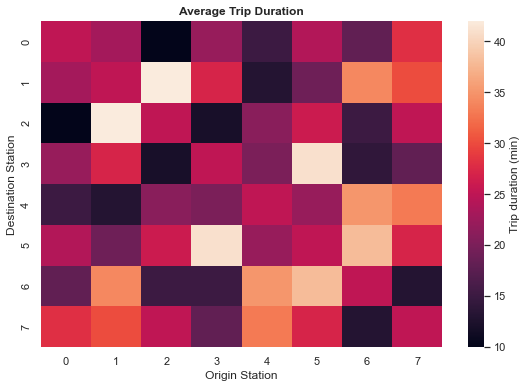

In [12]:
plt.figure(figsize = (9,6))
plt.title('Average Trip Duration')
#x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
sns.heatmap(traveldist, cbar_kws={'label': 'Trip duration (min)'})
plt.xlabel('Origin Station')
plt.ylabel('Destination Station')
plt.show()

In [6]:
traveldist

,0,1,2,3,4,5,6,7
0,25,23,10,22,15,24,18,28
1,23,25,42,27,13,19,34,30
2,10,42,25,12,21,26,15,25
3,22,27,12,25,20,41,14,18
4,15,13,21,20,25,22,35,33
5,24,19,26,41,22,25,38,27
6,18,34,15,15,35,38,25,13
7,28,30,25,18,33,27,13,25


<b> Infer Average Demand from Data </b> 

The code below counts the total number of trips at the day from i to j at time t.
Thus, a demand matrix, dMatrix can be created.

In [13]:
df['weekday_num'] = df['weekday']
for i in range(len(df)): 
    if df['weekday'][i] == 'Mon': 
        df['weekday_num'][i] = 0
    if df['weekday'][i] == 'Tue': 
        df['weekday_num'][i] = 1
    if df['weekday'][i] == 'Wed': 
        df['weekday_num'][i] = 2
    if df['weekday'][i] == 'Thu': 
        df['weekday_num'][i] = 3
    if df['weekday'][i] == 'Fri': 
        df['weekday_num'][i] = 4
    if df['weekday'][i] == 'Sat': 
        df['weekday_num'][i] = 5
    if df['weekday'][i] == 'Sun': 
        df['weekday_num'][i] = 6   

In [14]:
dSimple = df[['weekday_num','origin','destination','start_hour']]

In [15]:
dMatrix = np.zeros((7,8,8,24))
for i in np.arange(len(dSimple)):
    dMatrix[dSimple.iloc[i][0]][dSimple.iloc[i][1]][dSimple.iloc[i][2]][int(dSimple.iloc[i][3])]= dMatrix[dSimple.iloc[i][0]][dSimple.iloc[i][1]][dSimple.iloc[i][2]][int(dSimple.iloc[i][3])] + 1

# Optimization Model for Where to Place EVs


## Assumptions

The model uses the following assumptions:


1. Customers pay 0.33 per min for renting a EV, as stated on blueSG's website (https://www.bluesg.com.sg/)
2. The initial placecment of EVs is based on the current demand distribution 
3. Assume that there are 5 workers, who can move a maximum of 5 vehicles per hours, so a total of 25 cars per hour can be moved
4. Assume that workers are paid $12 dollars per hour (regardless of the number of cars moved)
5. Since the workers are not making additional stops, assume that the time they take to move a car is 80% of customers' travel time 
6. Assume that the average time taken to travel between any 2 stations is as shown by the travel time matrix above 
7. Assume that a service level of at least 95% should be obtained
8. The day starts from midnight(0am) 
9. Assume that the data is updated hourly 
10. Assume that there are sufficient charging points available at the 8 stations 
11. The model is based on 30 EVs and 8 charging locations over 1 week, which is used as an estimate for blueSG's fleet 


## Sets

1. $Days = \{0,1,2,3,4,5,6\}$: From Monday to Sunday
2. $Z =\{0,1,2,3,..., 8\}$: 8 charging stations (which are also pick-up and drop-off points)
3. $T =\{0,1,2,3,...,23\}$: Hours of the day

## Decision Variables

The following are the decision variables:

1. $R_{Day,i,j,t}$: number of EVs to move at $D \in Days$ from location $i\in Z$ to location $j\in Z$ at time $t\in T$
2. $X_{Day,i,j,t}$: number of customer trips satisfied at $D \in Days$ from $i\in Z$ to location $j\in Z$ at time $t\in T $
3. $W_{Day,i,t}$: number of EVs available at $D \in Days$ $i\in Z$ at the beginning of $t\in T$

## Parameters
### Parameters from the data set

1.$D_{Day,i,j,t}$: demand Day from location i to j at time t


### Parameters based on online information and assumptions
2.**price** : 0.33 dollar per min, as set on blueSG's the website 

4.**wagePerHour**: The workers are paid 12 dollars per hour

## Objective Function

The objective function maximizes profit by minimising the cost of moving EVs:

$$\max\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T} (X_{Day, i,j,t}*tripTime_{i,j}*price - wagePerHour  * R_{Day,i,j,t}*tripTime_{i,j}*0.8)$$

## Constraints



**1. At the start, the EVs are placed based on the total demand distribution**

$$w_{0,i,0} = \frac {d_i}{d_{total}} * 30,\quad \forall i \in Z $$

**2. Number of Cars** 

(A) The number of cars availabe at the beginning of the hour = the number of cars available at the beginning at the last hour - cars that went out in the previous hour + cars that entered in the previous hour + cars that were moved in at the end of the previous hour - cars that were moved out at the end of the previous hour

(B) The number of cars at the beginning of the day = the number of cars there at the end of the previous day**


<i> For 0 am </i>

$$W_{Day,i,t}=W_{Day-1,i,23}-\sum_{j\in Z}X_{Day-1,i,j,23}+\sum_{j\in Z}X_{Day-1,j,i,23}+\sum_{j\in Z}r_{Day-1,j,i,23}-\sum_{j\in Z}r_{Day-1,i,j,23}, \quad \forall Day \in [1,7],\forall i \in Z,  t \in [0]$$


<i> For the rest of the day </i>

$$W_{Day,i,t}=W_{Day,i,t-1}-\sum_{j\in Z}X_{Day,i,j,t-1}+\sum_{j\in Z}X_{Day,j,i,t-1}+\sum_{j\in Z}r_{Day,j,i,t-1}-\sum_{j\in Z}r_{Day,i,j,t-1}, \quad \forall Day \in Days,\forall i \in Z, \forall t \in [1,23]$$



**3. The trips need to be less or equal to the demand**
$$x_{Day,i,j,t}\leq d_{Day,i,j,t},\quad \forall Day \in Days,\forall i,j \in Z,\forall t \in T$$

<br></br>

**4. Service level is 0.95**
$$\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T} x_{Day,i,j,t} \geqslant 0.95*\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T}d_{Day,i,j,t}$$

<br></br>

**5. Trips satisfied need to be less than the available EVs at the beginning of the hour:**
$$x_{Day,i,j,t}\leq w_{Day,i,t} \quad \forall Day \in Days,\forall i,j \in Z,\forall t \in T$$

<br></br>

**6. A maximum of 25 cars can be moved per hour**
$$ \sum_{i\in Z} \sum_{j\in Z} R_{Day,i,j,t} \leq 70, \quad \forall Day \in Days, \forall t\in T $$

In [18]:
R={}
X = {} 
W={}

model = Model('Model1')

for Day in np.arange(7): #number of days
    for i in np.arange(8): #origin
        for j in np.arange(8): #destination
            for t in np.arange(24): #time of day
                R[(Day,i,j,t)] = model.addVar(lb = 0)
                X[(Day,i,j,t)] = model.addVar(lb = 0)
                W[(Day,i,t)] = model.addVar(lb = 0)
            

Restricted license - for non-production use only - expires 2023-10-25


In [19]:
#constraints 
# 1. The EVs are placed based on the total demand distribution:
d_total = sum(df.groupby('origin')['origin'].count())

available_EV={}
total_available_EV = {}

for i in np.arange(8):
    available_EV[(0,i,0)] = model.addConstr(W[(0,i,0)]== df.groupby('origin')['origin'].count()[i]/d_total * 30)


In [20]:
#2.The number of cars need to be updated each hour: the number of cars availabe at the beginning of the hour equals to 
#the number of the car available at the beginning at the last hour - 
#the car went out + the car went in + the car moved in - the car moved out

# the number of cars at the beginning of the day is based on the number at the end of the previous day 
for Day in np.arange(1,7):    
    for i in np.arange(8):
        available_EV[(Day,i,0)]=model.addConstr(W[(Day,i,0)]== W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                - quicksum(R[Day-1,i,j,23] for j in range(8))
                                               + quicksum(R[Day-1,j,i,23] for j in range(8)))
# for the rest of the day
for Day in np.arange(7):
    for i in np.arange(8):
        for t in np.arange(1,24):
            available_EV[(Day,i,t)]= model.addConstr(W[(Day,i,t)] == W[(Day,i,t-1)]- quicksum(X[Day,i,j,t-1] for j in range(8)) 
                                                 + quicksum(X[Day,j,i,t-1] for j in range(8)) 
                                                 - quicksum(R[Day,i,j,t-1] for j in range(8))
                                                 + quicksum(R[Day,j,i,t-1] for j in range(8)))


In [13]:
#3.The trips need to be less or equal to the demand
demand = {}
for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in np.arange(24):
                demand[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<=dMatrix[Day][i][j][t])

In [14]:
#4. Service level is 0.95

service_level = {}
service_level[0] = model.addConstr(quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]for Day in range(7)) for i in range(8))for j in range(8))for t in range(24))>=0.95*469 )

In [15]:
#5.  Trips satisfied need to be less than the available EVs at the beginning of the hour:
trips_satisfied={}
for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in np.arange(24):
                trips_satisfied[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<=W[(Day,i,t)])

    
# Workers can only move a maximum of 25 cars per hour 
move={}
for D in range(7):
    for t in range(24):
        move[(D,t)]=model.addConstr(quicksum(quicksum(R[(D,i,j,t)]for i in range(8))for j in range(8))<=25)

In [23]:
#average time taken to move between any 2 stations
triptime = np.array(traveldist)
traveldist

,0,1,2,3,4,5,6,7
0,25,23,10,22,15,24,18,28
1,23,25,42,27,13,19,34,30
2,10,42,25,12,21,26,15,25
3,22,27,12,25,20,41,14,18
4,15,13,21,20,25,22,35,33
5,24,19,26,41,22,25,38,27
6,18,34,15,15,35,38,25,13
7,28,30,25,18,33,27,13,25


In [24]:
#objective function with distance
obj = quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]*triptime[i][j]*0.33 - 12/60* R[(Day,i,j,t)] * triptime[i][j]*0.8 for i in range(8))for j in range(8))for t in range(24)) for Day in range(7)) 
model.setObjective(obj, GRB.MAXIMIZE)

In [25]:
model.optimize()
base_model=model.ObjVal
print("The optimal solution will result in a profit of:", "$",model.objVal, "for a week, $",model.objVal/7,"for a day") 

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 23017 rows, 32256 columns and 93848 nonzeros
Model fingerprint: 0x4d712dd6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 21092 rows and 21154 columns
Presolve time: 0.09s
Presolved: 1925 rows, 11102 columns, 32485 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.326e+03
 Factor NZ  : 3.563e+04 (roughly 6 MBytes of memory)
 Factor Ops : 7.221e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.17 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 703 iterations and 0.17 seconds
Optimal objective  3.669297292e+03
The optimal solution will result in a profit of: $ 3669.297292110876 for a week,

In [26]:
quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)].x for i in range(8))for j in range(8))for t in range(24)) for Day in range(7))

<gurobi.LinExpr: 469.0>

There are 469 trips during the week.

In [27]:
quicksum(quicksum(quicksum(quicksum(R[(Day,i,j,t)].x for i in range(8))for j in range(8))for t in range(24)) for Day in range(7))

<gurobi.LinExpr: 26.601279317697227>

We would move 24 cars to meet the demand during the week


In [28]:
car_moved = np.zeros(24)
for Day in range(7):
    for i in range(8):
        for j in range(8):
            for t in range(24):
                car_moved[t] += R[Day,i,j,t].x
car_moved

array([2.        , 4.        , 0.47761194, 0.12153518, 0.0575693 ,
       3.        , 1.11513859, 3.        , 0.        , 0.52238806,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       2.38166311, 1.        , 2.        , 1.        , 1.        ,
       0.        , 1.92537313, 1.        , 1.        ])

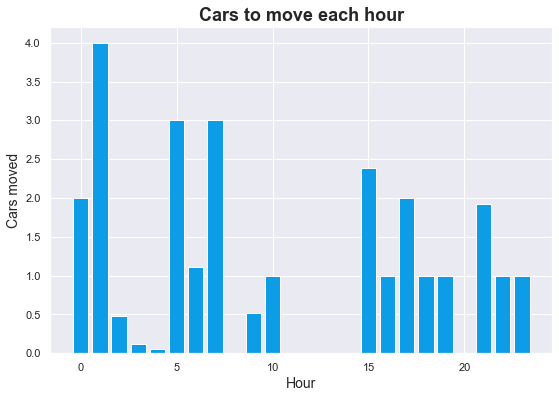

In [29]:
plt.rcParams['figure.figsize'] = [9, 6]
BIGGER_SIZE = 18  
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = "bold")
plt.bar(np.arange(24),car_moved,facecolor='#0C9DE6')
plt.xlabel('Hour')
plt.ylabel('Cars moved')
plt.title('Cars to move each hour')
plt.show()

In [30]:
car_movedi = np.zeros(8)
for Day in range(7):
    for i in range(8):
        for j in range(8):
            for t in range(24):
                car_movedi[i] += R[Day,i,j,t].x
car_movedi

array([3.04690832, 0.        , 3.        , 4.01918977, 9.        ,
       0.        , 5.53518124, 2.        ])

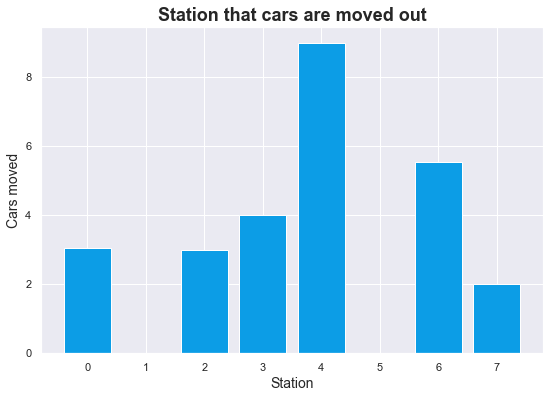

In [31]:
plt.bar(np.arange(8),car_movedi,facecolor='#0C9DE6')
plt.xlabel('Station')
plt.ylabel('Cars moved')
plt.title('Station that cars are moved out')
plt.show()

Many cars are moved out of station 4, thus there might be excess cars there. 

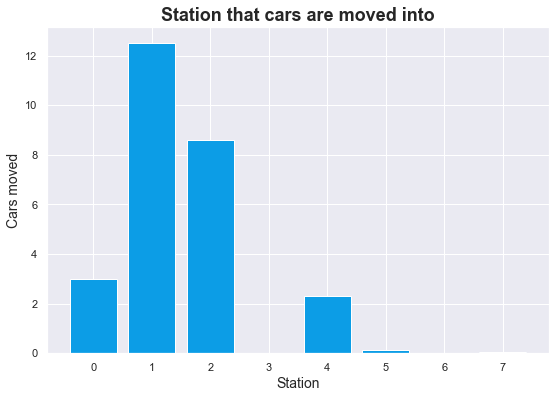

In [32]:
car_movedj = np.zeros(8)
for Day in range(7):
    for i in range(8):
        for j in range(8):
            for t in range(24):
                car_movedj[j] += R[Day,i,j,t].x
plt.bar(np.arange(8),car_movedj,facecolor='#0C9DE6')
plt.xlabel('Station')
plt.ylabel('Cars moved')
plt.title('Station that cars are moved into')
plt.show()

Most cars are moved to stations 1 & 2, thus those areas are lacking cars.

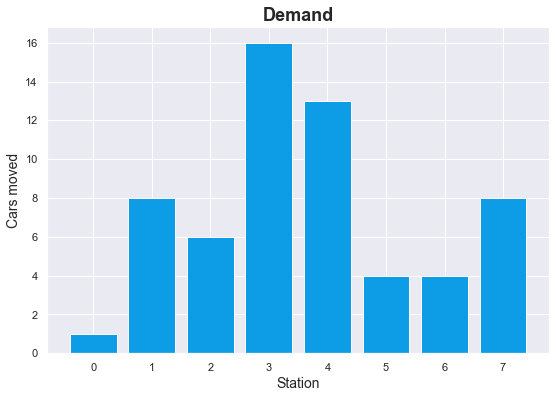

In [33]:
car_movedM = np.zeros(8)
for i in range(8):
    for j in range(8):
        for t in range(24):
            car_movedM[i] += X[0,i,j,t].x
plt.bar(np.arange(8),car_movedM,facecolor='#0C9DE6')
plt.xlabel('Station')
plt.ylabel('Cars moved')
plt.title('Demand')
plt.show()

# 4. Problem B - Factoring in Charging

## Additional Assumptions related to charging 
1. 10% of the cars used need to be charged
2. EVs need 4 hours to charge
3. There may be a lack of charging points at station 3 and 4, thus we move 30% of cars out to the other charging stations

## Objective function is unchanged

$$\max\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T} (X_{Day,i,j,t}*tripTime_{i,j}*price - wagePerHour  * R_{Day,i,j,t}*tripTime_{i,j}*0.8)$$

## Decision Variables

Following decision variables:

1. $R_{Day,i,j,t}$: number of EVs to move at $D \in Days$ from station $i\in Z$ to station $j\in Z$ at time $t\in T$
2. $X_{Day,i,j,t}$: number of customer trips satisfied at $D \in Days$ from $i\in Z$ to station $j\in Z$ at time $t\in T $
3. $W_{Day,i,t}$: number of EVs available at $D \in Days$ $i\in Z$ at the beginning of $t\in T$

With an added variable: 

4. $RC_{Day,i,j,t}$ number of EVs that are charging $D \in Days$ at time $t\in T$ 

## Constraints

**1. At the start, the 30 EVs are placed based on the total demand distribution**

$$w_{0,i,0} = \frac {d_i}{d_{total}} * 30,\quad \forall i \in Z $$

<br>

**2. Number of cars that need charging is 10% of the trips satisfied:**

$$RC_{Day,i,j,t} = 0.1*X_{Day,i,j,t}\quad \forall Day \in Days,\forall i \in Z,\forall j \in Z, \forall t \in T$$

<br>


**3.The number of cars need to be updated each hour:**

The number of cars availabe at the beginning of the hour equals to the number of cars available at the beginning at the last hour - cars that went out in the previous hour + cars that entered in the previous hour + cars that were moved in to meet the demand at the end of the previous hour - cars that were moved out to meet the demand at the end of the previous hour - cars being charged + cars that finished charging<br>
<br>
$$W_{Day,i,t}=W_{Day,i,t-1}-\sum_{j\in Z}X_{Day,i,j,t-1}+\sum_{j\in Z}X_{Day,j,i,t-1}+\sum_{j\in Z}R_{Day,j,i,t-1}-\sum_{j\in Z}R_{Day,i,j,t-1} - \sum_{j\in Z}\sum_{ic \in CS}RC_{Day,j,i,t-1}+\sum_{j\in Z}\sum_{ii \in Z}RC_{Day,j,i,t-4}$$ 
$$\quad \forall Day \in Days,\forall i \in Z, \forall j \in Z, \forall t \in T $$

<br>

4.The trips need to be less or equal to the demand
$$x_{Day,i,j,t}\leq d_{Day,i,j,t},\quad \forall Day \in Days,\forall i,j \in Z,\forall t \in T$$

<br><br>
5.Service level is 0.95
$$\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T} X_{Day,i,j,t} \geqslant 0.95*\sum_{Day\in Days}\sum_{i\in Z}\sum_{j\in Z}\sum_{t \in T}demand_{Day,i,j,t}$$

<br>

6.Trips satisfied need to be less than the available EVs at the beginning of the hour:
$$x_{Day,i,j,t}\leq w_{Day,i,t} \quad \forall Day \in Days,\forall i,j \in Z,\forall t \in T$$


<br>
7.Maximum cars can be moved is 25 
$$ \sum_{i\in Z} \sum_{j\in Z} R_{Day,i,j,t} +\sum_{i\in Z} \sum_{j\in Z}\sum_{ic\in SC} RC_{Day,i,j,t,ic} \leq 25, \quad \forall Day \in Days, \forall t\in T $$

There might be a lack of charging points at stations 1, 3 and 4

In [34]:
all_charging_points = [0,1,2,3,4,5,6,7]

In [35]:
R={}
X = {} 
W={}
RC = {}

model = Model('Model2')

for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in np.arange(24):
                R[(Day,i,j,t)] = model.addVar(lb = 0)
                X[(Day,i,j,t)] = model.addVar(lb = 0)
                W[(Day,i,t)] = model.addVar(lb = 0)
                
for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in range(24):
                for ic in all_charging_points: #CHANGE THIS 
                    RC[Day,i,j,t] = model.addVar(lb = 0)
                    

# 1. The EVs are placed based on the total demand distribution:
available_EV={}

for i in np.arange(8):
    available_EV[(0,i,0)]=model.addConstr(W[(0,i,0)]== df.groupby('origin')['origin'].count()[i]/d_total * 30)

for Day in np.arange(1,7):    
    for i in np.arange(8):
        available_EV[(Day,i,0)]=model.addConstr(W[(Day,i,0)]== W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                 + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                 - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                 + quicksum(R[Day-1,j,i,23] for j in range(8)))
        
# finish charging
for Day in np.arange(7):
    for i in all_charging_points:
        for t in np.arange(4,24):# 24
            available_EV[(Day,i,t)]= model.addConstr(W[(Day,i,t)] == W[(Day,i,t-1)]- quicksum(X[Day,i,j,t-1] for j in range(8)) 
                                                 + quicksum(X[Day,j,i,t-1] for j in range(8)) 
                                                 - quicksum(R[Day,i,j,t-1] for j in range(8))
                                                 + quicksum(R[Day,j,i,t-1] for j in range(8))
                                                 - quicksum(RC[Day,j,i,t-1] for j in range(8))
                                                 + quicksum(RC[Day,j,i,t-4] for j in range(8)))  #finish charging
            
#3.The trips need to be less or equal to the demand
demand = {}
for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in np.arange(24):
                demand[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<=dMatrix[Day][i][j][t])
                
#4. Service level is 0.95

service_level = {}
service_level[0] = model.addConstr(quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]for Day in range(7)) for i in range(8))for j in range(8))for t in range(24))>=0.95*469 )

#5.  Trips satisfied need to be less than the available EVs at the beginning of the hour:
trips_satisfied={}
for Day in np.arange(7):
    for i in np.arange(8):
        for j in np.arange(8):
            for t in np.arange(24):
                trips_satisfied[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<= W[(Day,i,t)])

    
# Workers can only move a maximum of 25 cars per hour 
move={}
for D in range(7):
    for t in range(24):
        move[(D,t)]=model.addConstr(quicksum(quicksum(R[(D,i,j,t)]for i in range(8))for j in range(8))<=25)
        
#average time taken to move between any 2 areas
triptime = np.array(traveldist)

## cars temporarily unavailable due to charging (10% of demand)
relocation_charging = {}

for Day in range(7):
    for t in range(24):
        for i in range(8):
            for j in range(8):
                relocation_charging[(Day,i,j,t)] = model.addConstr(RC[Day,i,j,t]==0.1*X[Day,i,j,t])  
                
#number of cars available for the first few hours of the day is affected by the last few hours of the previous day
for Day in np.arange(1,7):
    for i in all_charging_points:
        available_EV[(Day,i,0)]= model.addConstr(W[(Day,i,0)] == W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                 + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                 - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                 + quicksum(R[Day-1,j,i,23] for j in range(8))
                                                 - quicksum(RC[Day-1,j,i,23] for j in range(8))
                                                 + quicksum(RC[Day-1,j,i,20] for j in range(8))) #done charging
        
for Day in np.arange(1,7):
    for i in all_charging_points:
        available_EV[(Day,i,1)]= model.addConstr(W[(Day,i,1)] == W[(Day-1,i,0)]- quicksum(X[Day-1,i,j,0] for j in range(8)) 
                                                 + quicksum(X[Day-1,j,i,0] for j in range(8)) 
                                                 - quicksum(R[Day-1,i,j,0] for j in range(8))
                                                 + quicksum(R[Day-1,j,i,0] for j in range(8))
                                                 - quicksum(RC[Day-1,j,i,0] for j in range(8))
                                                 + quicksum(RC[Day-1,j,i,21] for j in range(8)))
        
for Day in np.arange(1,7):
    for i in all_charging_points:
        available_EV[(Day,i,2)]= model.addConstr(W[(Day,i,2)] == W[(Day-1,i,1)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                 + quicksum(X[Day-1,j,i,1] for j in range(8)) 
                                                 - quicksum(R[Day-1,i,j,1] for j in range(8))
                                                 + quicksum(R[Day-1,j,i,1] for j in range(8))
                                                 - quicksum(RC[Day-1,j,i,1] for j in range(8))
                                                 + quicksum(RC[Day-1,j,i,21] for j in range(8)))
        
for Day in np.arange(1,7):
    for i in all_charging_points:
        available_EV[(Day,i,3)]= model.addConstr(W[(Day,i,3)] == W[(Day-1,i,2)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                 + quicksum(X[Day-1,j,i,2] for j in range(8)) 
                                                 - quicksum(R[Day-1,i,j,2] for j in range(8))
                                                 + quicksum(R[Day-1,j,i,2] for j in range(8))
                                                 - quicksum(RC[Day-1,j,i,2] for j in range(8))
                                                 + quicksum(RC[Day-1,j,i,23] for j in range(8)))
                

In [36]:
obj = quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]*triptime[i][j]*0.33 
                                          - 12/60* R[(Day,i,j,t)] * triptime[i][j]*0.8  for i in range(8))for j in range(8))for t in range(24)) for Day in range(7)) 
                                          
model.setObjective(obj, GRB.MAXIMIZE) 

model.optimize()
base_model=model.ObjVal
print("The optimal solution will result in a profit of:", "$",model.objVal, "for a week, $",model.objVal/7,"for a day") 

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 33793 rows, 118272 columns and 137256 nonzeros
Model fingerprint: 0xe662c239
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 31987 rows and 111586 columns
Presolve time: 0.13s
Presolved: 1806 rows, 6686 columns, 19865 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.648e+03
 Factor NZ  : 4.090e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.030e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.22667875e+06  9.49287180e+03  4.02e+03 0.00e+00  1.56e+03     0s

Barrier performed 0 iterations in 0.17 seconds
Barrier solve interrupted - model solved by

Profit is lowered to 3615 dollars per week. This decrease is due to some cars being unavailable due to charging.  

In [37]:
quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)].x for i in range(8))for j in range(8))for t in range(24)) for Day in range(7))

<gurobi.LinExpr: 452.0>

There is 452 trips completed

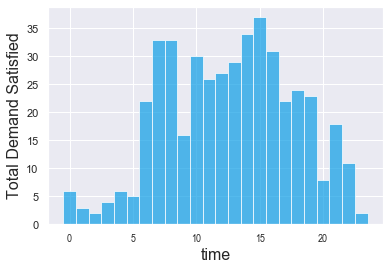

In [38]:
car_moved = np.zeros(24)
for Day in range(7):
    for i in range(1):
        for j in range(8):
            for t in range(24):
                car_moved[t] = quicksum(quicksum(quicksum(X[(Day,i,j,t)].x for i in range(8))for j in range(8)) for Day in range(7)).getValue()
Table().with_columns('time',np.arange(24),
                    'Total Demand Satisfied',car_moved).bar('time','Total Demand Satisfied',facecolor='#0C9DE6')

## Varying the Percentage of Vehicles that Require Charging

In [39]:
def no_EV_charging (charging_percentage):

    R={}
    X = {} 
    W={}
    RC = {}
    model = Model('charging')

    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    R[(Day,i,j,t)] = model.addVar(lb = 0)
                    X[(Day,i,j,t)] = model.addVar(lb = 0)
                    W[(Day,i,t)] = model.addVar(lb = 0)

    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in range(24):
                    for ic in all_charging_points: 
                        RC[Day,i,j,t] = model.addVar(lb = 0)


    # 1. The EVs are placed based on the total demand distribution:
    available_EV={}

    for i in np.arange(8):
        available_EV[(0,i,0)]=model.addConstr(W[(0,i,0)]== df.groupby('origin')['origin'].count()[i]/d_total * 30)

    for Day in np.arange(1,7):    
        for i in np.arange(8):
            available_EV[(Day,i,0)]=model.addConstr(W[(Day,i,0)]== W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,23] for j in range(8)))

    # finish charging
    for Day in np.arange(7):
        for i in all_charging_points:
            for t in np.arange(4,24):# 24
                available_EV[(Day,i,t)]= model.addConstr(W[(Day,i,t)] == W[(Day,i,t-1)]- quicksum(X[Day,i,j,t-1] for j in range(8)) 
                                                     + quicksum(X[Day,j,i,t-1] for j in range(8)) 
                                                     - quicksum(R[Day,i,j,t-1] for j in range(8))
                                                     + quicksum(R[Day,j,i,t-1] for j in range(8))
                                                     - quicksum(RC[Day,j,i,t-1] for j in range(8))
                                                     + quicksum(RC[Day,j,i,t-4] for j in range(8)))  #finish charging

    #3.The trips need to be less or equal to the demand
    demand = {}
    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    demand[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<=dMatrix[Day][i][j][t])

    #4. Service level is 0.95

    service_level = {}
    service_level[0] = model.addConstr(quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]for Day in range(7)) for i in range(8))for j in range(8))for t in range(24))>=0.95*469 )

    #5.  Trips satisfied need to be less than the available EVs at the beginning of the hour:
    trips_satisfied={}
    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    trips_satisfied[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<= W[(Day,i,t)])


    # Workers can only move a maximum of 50 cars per hour 
    move={}
    for D in range(7):
        for t in range(24):
            move[(D,t)]=model.addConstr(quicksum(quicksum(R[(D,i,j,t)]for i in range(8))for j in range(8))<=50)

    #average time taken to move between any 2 areas
    triptime = np.array(traveldist)

    ## cars temporarily unavailable due to charging (10% of demand)
    relocation_charging = {}

    for Day in range(7):
        for t in range(24):
            for i in range(8):
                for j in range(8):
                    relocation_charging[(Day,i,j,t)] = model.addConstr(RC[Day,i,j,t]==charging_percentage*X[Day,i,j,t])  

    #number of cars available for the first few hours of the day is affected by the last few hours of the previous day
    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,0)]= model.addConstr(W[(Day,i,0)] == W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,23] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,23] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,20] for j in range(8))) #done charging

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,1)]= model.addConstr(W[(Day,i,1)] == W[(Day-1,i,0)]- quicksum(X[Day-1,i,j,0] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,0] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,0] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,0] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,0] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,21] for j in range(8)))

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,2)]= model.addConstr(W[(Day,i,2)] == W[(Day-1,i,1)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,1] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,1] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,1] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,1] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,21] for j in range(8)))

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,3)]= model.addConstr(W[(Day,i,3)] == W[(Day-1,i,2)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,2] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,2] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,2] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,2] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,23] for j in range(8)))
            
    obj = quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]*triptime[i][j]*0.33 
                                          - 12/60* R[(Day,i,j,t)] * triptime[i][j]*0.8  for i in range(8))for j in range(8))for t in range(24)) for Day in range(7)) 
                                          
    model.setObjective(obj, GRB.MAXIMIZE) 
    model.optimize()
    return model.objVal

    base_model=model.ObjVal
    print("The optimal solution will result in a profit of:", "$",model.objVal, "for a week, $",model.objVal/7,"for a day") 

In [40]:
chargePercent=[0.05,0.10,0.20,0.30]


EV_array = np.zeros(len(chargePercent))

for i in np.arange(len(chargePercent)):
    EV_array[i] = no_EV_charging(chargePercent[i])
EV_array

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 33793 rows, 118272 columns and 137256 nonzeros
Model fingerprint: 0xb454dad3
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 31987 rows and 111586 columns
Presolve time: 0.14s
Presolved: 1806 rows, 6686 columns, 19865 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.648e+03
 Factor NZ  : 4.090e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.030e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.75185558e+06  9.49463568e+03  5.71e+03 0.00e+00  2.22e+03     0s
   1  -1.14540224e+06  1.18003730e+05  3.71e+03 4.46e+00  1.31e+03     0s

Barrier performe

array([3615.21703198, 3615.00903198, 3614.59303198, 3614.17703198])

Text(0, 0.5, 'Profit')

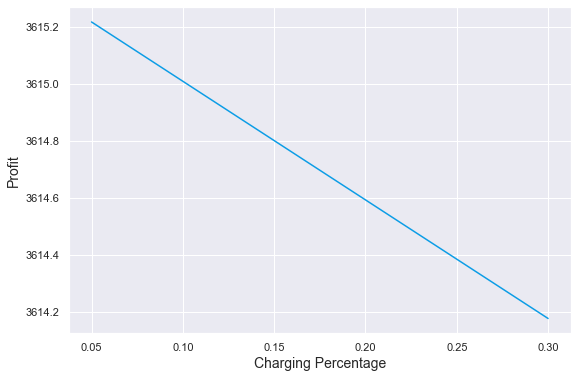

In [41]:
plt.plot(chargePercent, EV_array,  '#0C9DE6')
plt.xlabel('Charging Percentage')
plt.ylabel('Profit')

From the graph above, the percentage of EVs that need charging and the profits have a negative linear relationships. Profit ranges from $3614.17 - 3615.21 weekly, thus the charging percentage varying wil not significantly affect profits. 

# 5. Problem C - Demand Uncertainty 

To see how the model handles **uncertainty** in demand, demands would be adjusted to randomly fluctuate from 60% to 140%. The number of cars that can be moved per hour is changed to 50 to meet the uncertainty.

In [42]:
import random
dMatrixUncertain = dMatrix.copy()

In [43]:
def uncertain(fluctuation):
    import random
    dMatrixUncertain = dMatrix.copy()
    for Day in range(7):
        for i in range(8):
            for j in range(8):
                for t in range(24):
                    dMatrixUncertain[Day][i][j][t] *= (1+random.randint(-fluctuation,fluctuation)/100)
    R={}
    X = {} 
    W={}
    RC = {}

    model = Model('Model3')

    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    R[(Day,i,j,t)] = model.addVar(lb = 0)
                    X[(Day,i,j,t)] = model.addVar(lb = 0)
                    W[(Day,i,t)] = model.addVar(lb = 0)

    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in range(24):
                    for ic in all_charging_points: #CHANGE THIS 
                        RC[Day,i,j,t] = model.addVar(lb = 0)


    # 1. The EVs are placed based on the total demand distribution:
    available_EV={}

    for i in np.arange(8):
        available_EV[(0,i,0)]=model.addConstr(W[(0,i,0)]== df.groupby('origin')['origin'].count()[i]/d_total * 30)

    for Day in np.arange(1,7):    
        for i in np.arange(8):
            available_EV[(Day,i,0)]=model.addConstr(W[(Day,i,0)]== W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,23] for j in range(8)))

    # finish charging
    for Day in np.arange(7):
        for i in all_charging_points:
            for t in np.arange(4,24):# 24
                available_EV[(Day,i,t)]= model.addConstr(W[(Day,i,t)] == W[(Day,i,t-1)]- quicksum(X[Day,i,j,t-1] for j in range(8)) 
                                                     + quicksum(X[Day,j,i,t-1] for j in range(8)) 
                                                     - quicksum(R[Day,i,j,t-1] for j in range(8))
                                                     + quicksum(R[Day,j,i,t-1] for j in range(8))
                                                     - quicksum(RC[Day,j,i,t-1] for j in range(8))
                                                     + quicksum(RC[Day,j,i,t-4] for j in range(8)))  #finish charging

    #3.The trips need to be less or equal to the demand
    demand = {}
    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    demand[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<=dMatrixUncertain[Day][i][j][t])

    #4. Service level is 0.95

    service_level = {}
    service_level[0] = model.addConstr(quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]for Day in range(7)) for i in range(8))for j in range(8))for t in range(24))>=0.95*469 )

    #5.  Trips satisfied need to be less than the available EVs at the beginning of the hour:
    trips_satisfied={}
    for Day in np.arange(7):
        for i in np.arange(8):
            for j in np.arange(8):
                for t in np.arange(24):
                    trips_satisfied[(Day,i,j,t)] = model.addConstr(X[(Day,i,j,t)]<= W[(Day,i,t)])


    # Workers can only move a maximum of 50 cars per hour 
    move={}
    for D in range(7):
        for t in range(24):
            move[(D,t)]=model.addConstr(quicksum(quicksum(R[(D,i,j,t)]for i in range(8))for j in range(8))<=50)

    #average time taken to move between any 2 areas
    triptime = np.array(traveldist)

    ## cars temporarily unavailable due to charging (10% of demand)
    relocation_charging = {}

    for Day in range(7):
        for t in range(24):
            for i in range(8):
                for j in range(8):
                    relocation_charging[(Day,i,j,t)] = model.addConstr(RC[Day,i,j,t]==0.1*X[Day,i,j,t])  

    #number of cars available for the first few hours of the day is affected by the last few hours of the previous day
    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,0)]= model.addConstr(W[(Day,i,0)] == W[(Day-1,i,23)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,23] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,23] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,23] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,23] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,20] for j in range(8))) #done charging

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,1)]= model.addConstr(W[(Day,i,1)] == W[(Day-1,i,0)]- quicksum(X[Day-1,i,j,0] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,0] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,0] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,0] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,0] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,21] for j in range(8)))

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,2)]= model.addConstr(W[(Day,i,2)] == W[(Day-1,i,1)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,1] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,1] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,1] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,1] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,21] for j in range(8)))

    for Day in np.arange(1,7):
        for i in all_charging_points:
            available_EV[(Day,i,3)]= model.addConstr(W[(Day,i,3)] == W[(Day-1,i,2)]- quicksum(X[Day-1,i,j,23] for j in range(8)) 
                                                     + quicksum(X[Day-1,j,i,2] for j in range(8)) 
                                                     - quicksum(R[Day-1,i,j,2] for j in range(8))
                                                     + quicksum(R[Day-1,j,i,2] for j in range(8))
                                                     - quicksum(RC[Day-1,j,i,2] for j in range(8))
                                                     + quicksum(RC[Day-1,j,i,23] for j in range(8)))
            
    obj = quicksum(quicksum(quicksum(quicksum(X[(Day,i,j,t)]*triptime[i][j]*0.33 
                                          - 12/60* R[(Day,i,j,t)] * triptime[i][j]*0.8  for i in range(8))for j in range(8))for t in range(24)) for Day in range(7)) 
                                          
    model.setObjective(obj, GRB.MAXIMIZE) 
    model.optimize()
    return model.objVal

    base_model=model.ObjVal
    print("The optimal solution will result in a profit of:", "$",model.objVal, "for a week, $",model.objVal/7,"for a day") 

In [44]:
fluc = [10,20,30,40]
EV_array = np.zeros(len(fluc))

for i in np.arange(len(fluc)):
    EV_array[i] = uncertain(fluc[i])

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 33793 rows, 118272 columns and 137256 nonzeros
Model fingerprint: 0x41815637
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 31988 rows and 111586 columns
Presolve time: 0.13s
Presolved: 1805 rows, 6686 columns, 19863 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.643e+03
 Factor NZ  : 4.087e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.030e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.46805572e+06  8.43692731e+03  8.07e+03 0.00e+00  2.69e+03     0s
   1  -1.58210258e+06  1.17179127e+05  5.15e+03 2.17e+00  1.53e+03     0s
   2  -1.52261759

AttributeError: Unable to retrieve attribute 'objVal'

Text(0, 0.5, 'Profit')

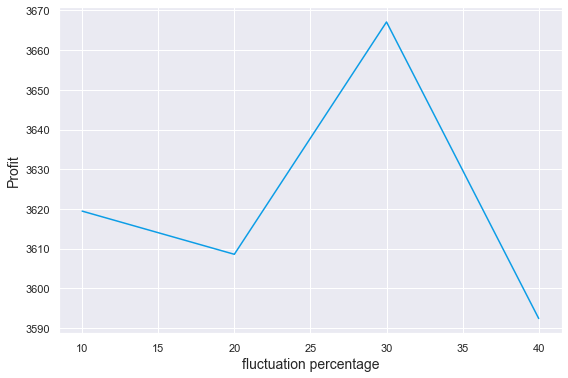

In [295]:
plt.plot(fluc, EV_array, '#0C9DE6')
plt.xlabel('fluctuation percentage')
plt.ylabel('Profit')

# 6. Conclusion & Future Developments

From the above 3 models, profit generally does not deviate significantly from around $3620 weekly. This model was made based on 30 EVs and 8 charging stations, thus the model can be expanded with a larger sample size to better estimate blueSG's full vehicle fleet.